# <center><font color='blue'>SkimLit</center></font>

## Table of contents
- [1 - Objetivos](#1)
- [2 - Librerías necesarias](#2)
- [3 - Carga y visualización de datos](#3)
- [4 - Pre-procesamiento de datos](#4)
    - [4.1. - Datos faltantes](#4.1)
    - [4.2. - Data Categóricos](#4.2)
    - [4.3. - Balanceo de clases](#4.3)
    - [4.4. - Pre-Procesamiento especial para NLP](#4.4)
- [5 - Modelos](#5)
    - [5.1. - Modelo 1](#5.1)
    - [5.2. - Modelo 2](#5.2)
    - [5.3. - Modelo 3](#5.3)
    - [5.4. - Modelo 4](#5.4)
    - [5.4. - Modelo 5](#5.5)
    - [5.4. - Modelo 6](#5.6)
    - [5.4. - Modelo 7](#5.7)
- [6 - Comparando los modelos y eligiendo el mejor](#6)
- [7 - Ajuste de hiperparámetros](#7)
- [8 - Predicciones con el modelo final](#8)
- [9 - Guardando el modelo](#9)
- [10 - Conclusiones](#10)

<a name="1"></a>
## <b> <font color='blue'> 1. Objectives </font> </b>
Build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071



<a name="2"></a>
## <b> <font color='blue'> 2. Setup </font> </b>

What we are looking for is to associate a specific label (objective, background, result...) with a given sentence (composed of many words), so it is a many-to-one problem.

### Modules

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [57]:
import csv
import random
import re

import numpy as np
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import layers, callbacks, models, Sequential, losses
from tensorflow import keras


In [3]:
from helper_functions import calculate_results

In [4]:
# random seed
tf.random.set_seed(42)

<a name="3"></a>
## <b> <font color='blue'> 3.  Data Loading and Visualization </font> </b>

Let's download the data.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct 

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: la ruta de destino 'pubmed-rct' ya existe y no es un directorio vacío.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


There are 2 datasets, one with 20000 examples (usefull for the initial tests) and another one with 200k examples.

In [6]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [7]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [8]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [9]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [10]:
# Let's read in the training lines and see some of them
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file

to_show = 15
train_lines[:to_show]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We see that the abstracts:

- Start with "###
- Followed by an ID and a newline character (\n)
- Each sentence has a label (for example RESULTS, METHODS..) (starting with the label and then \t)
- The end is indicated by a newline charecter (\n).

<br>
We need a function to separate the text from the labels and the different abstracts.

<a name="4"></a>
## <b> <font color='blue'> 4.  Data pre-processing </font> </b>


<a name="4.1"></a>
### <b> <font color='#1F618D'> 4.1. Formatting our data </font> </b>

We want that our data looks like this:

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

total lines it's the number of lines in the abstract (that we want to classify sequentially)

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.


In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [12]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [13]:
# Check the first abstract of our training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Let's create dataframes:

In [14]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<a name="4.2"></a>
### <b> <font color='#1F618D'> 4.2. More visualization </font> </b>

#### Number of classes and class balance

In [15]:
num_classes = train_df['target'].nunique()
num_classes

5

In [16]:
# Distribution of labels in training data
train_df.target.value_counts(normalize=True)

METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: target, dtype: float64

#### Total lines distribution

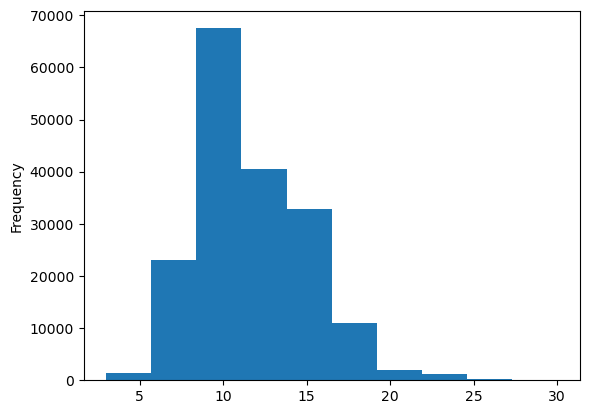

In [17]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(); 

#### Sentences

In [18]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
# View 5 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [20]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

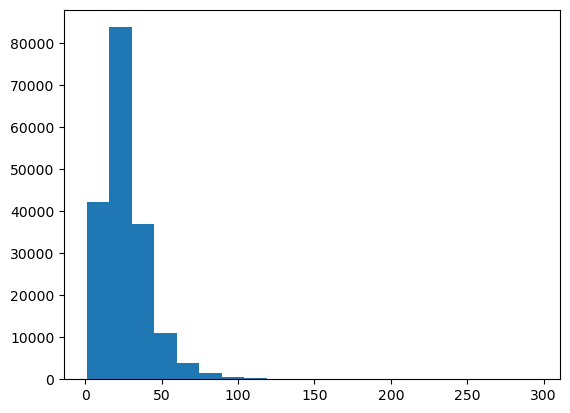

In [21]:
# What's the distribution look like?
plt.hist(sent_lens, bins=20);

In [22]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [23]:
# Maximum sequence length in the training set
max(sent_lens)

296

<a name="4.3"></a>
### <b> <font color='#1F618D'> 4.3. Categorical Data </font> </b>

We will use one-hot encoding for our targets, since there are no ordinal relationship between them.

In [24]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))

# here there is no fit, we fit with the training data only
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

<a name="4.4"></a>
### <b> <font color='#1F618D'> 4.4. Pre-processing for NLP </font> </b>

#### Create text vectorizer layer

In [25]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [26]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [27]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [28]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
clinicaltrials.gov ( no.nct@ ) .

Length of text: 5

Vectorized text: [[  275 51037     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Let's observe that it pads with zeros up to the specified output sequence length (output_seq_length, which is 55 in this case).

In [29]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [30]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

<b> 
We will apply it later as the first layer of the model after obtaining the input. </b>

<a name="4.5"></a>
### <b> <font color='#1F618D'> 4.5. Creating tensorflow datasets </font> </b>

In [31]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [32]:
for x, y in train_dataset.take(1):
    print(f"Text: {x}\n")
    print(f"Label: {y}")

Text: b'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

Label: [0. 0. 0. 1. 0.]


In [33]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

<a name="5"></a>
## <b> <font color='blue'> 5. Models </font> </b>

In [34]:
# to save results and compare
results = {}

In [35]:
# constants
INPUT_SHAPE=(1,)
BATCH_SIZE = 32
NUM_CLASSES=num_classes

<a name="5.1"></a>
### <b> <font color='#1F618D'> 5.1. Embedding layer </font> </b>

In [36]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt 
                                               #numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [37]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 clinicaltrials.gov ( no.nct@ ) .

Sentence after vectorization (before embedding):
 [[  275 51037     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.00278814 -0.00782514  0.00502338 ...  0.00608988  0.01728872
    0.03932072]
  [-0.03076228  0.02473908 -0.02631815 ...  0.02934201 -0.02827568
   -0.04883878]
  [-0.03577381  0.03711834  0.00194106 ... -0.02293947 -0.00237385
   -0.01066438]
  ...
  [-0.03577381  0.03711834  0.00194106 ... -0.02293947 -0.00237385
   -0.01066438]
  [-0.03577381  0.03711834  0.00194106 ... -0.02293947 -0.00237385
   -0.01066438]
  [-0.03577381  0.03711834  0.00194106 ... -0.02293947 -0.00237385
   -0.01066438]]]

Embedde

<a name="5.2"></a>
### <b> <font color='#1F618D'> 5.2. Trying different models </font> </b>

<a name="5.2.1"></a>
### <b> <font color='#5499C7'> 5.2.1. Model 1: Conv1D </font> </b>

In [38]:
def build_model_1(name, input_shape = INPUT_SHAPE, num_classes = NUM_CLASSES):
    inputs = layers.Input(shape=input_shape,dtype=tf.string)
    x = text_vectorizer(inputs)
    x = token_embed(x)
    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model


model_1 = build_model_1('model_1')

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                           

In [39]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # one-hot encoded labels
    metrics=['accuracy', 'Precision', 'Recall']
)


history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    batch_size=BATCH_SIZE,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 56s 95ms/step - loss: 0.9133 - accuracy: 0.6390 - precision: 0.8422 - recall: 0.4365 - val_loss: 0.6797 - val_accuracy: 0.7404 - val_precision: 0.8220 - val_recall: 0.6403
Epoch 2/3
562/562 [==============================] - 53s 94ms/step - loss: 0.6509 - accuracy: 0.7612 - precision: 0.8211 - recall: 0.6779 - val_loss: 0.6201 - val_accuracy: 0.7729 - val_precision: 0.8354 - val_recall: 0.6832
Epoch 3/3
562/562 [==============================] - 53s 94ms/step - loss: 0.6109 - accuracy: 0.7791 - precision: 0.8306 - recall: 0.7109 - val_loss: 0.5886 - val_accuracy: 0.7866 - val_precision: 0.8424 - val_recall: 0.7161


In [40]:
# evaluate
model_1.evaluate(test_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.6057 - accuracy: 0.7848 - precision: 0.8339 - recall: 0.7113


[0.6057083606719971,
 0.7848349213600159,
 0.8338844776153564,
 0.7112991809844971]

In [41]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.28774834e-01, 1.68251917e-01, 1.02722846e-01, 2.65677005e-01,
         3.45733836e-02],
        [4.13164556e-01, 2.76556671e-01, 1.53431678e-02, 2.86529124e-01,
         8.40652827e-03],
        [1.45700872e-01, 8.39200523e-03, 9.60013014e-04, 8.44913423e-01,
         3.35480654e-05],
        ...,
        [5.29656018e-06, 6.41092018e-04, 6.71797490e-04, 2.96929943e-06,
         9.98678863e-01],
        [5.35815768e-02, 4.76589054e-01, 1.21477269e-01, 6.73734695e-02,
         2.80978620e-01],
        [1.52904049e-01, 7.19598532e-01, 4.49868105e-02, 3.35396640e-02,
         4.89710085e-02]], dtype=float32),
 (30212, 5))

In [42]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

<a name="5.2.2"></a>
### <b> <font color='#5499C7'> 5.2.2. Model 2: Feature extraction with pre-trained token embeddings </font> </b>

In [43]:
import tensorflow_hub as hub

In [44]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [45]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 precooling reduced heart rate by @-@ beats/min during the first @ minutes of exercise , but this attenuation ended by @ minutes .
Setence after embedding:
[-0.07699895  0.07551625 -0.03682434 -0.03275819 -0.06498258  0.0073762
  0.03149137  0.02503615  0.07212464  0.08609689  0.06361227 -0.03678966
  0.00547011 -0.06675193  0.01723996  0.018016   -0.08764568  0.03007391
  0.00684226  0.02999714 -0.07922672 -0.03583154 -0.02463942  0.03485842
 -0.06445628  0.04210879  0.02487477  0.02881389 -0.07226319  0.03156975]

Length of sentence embedding: 512


In [46]:
def build_model_2(name, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape, dtype=tf.string)
    x = tf_hub_embedding_layer()(inputs)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model


model_2 = build_model_1('model_2_USE_feature_extractor')
    
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                     

In [47]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # one-hot encoded labels
    metrics=['accuracy']
)


history_model_2 = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 55s 96ms/step - loss: 0.6605 - accuracy: 0.7660 - val_loss: 0.6066 - val_accuracy: 0.7796
Epoch 2/3
562/562 [==============================] - 54s 96ms/step - loss: 0.4878 - accuracy: 0.8307 - val_loss: 0.5991 - val_accuracy: 0.7809
Epoch 3/3
562/562 [==============================] - 53s 95ms/step - loss: 0.4683 - accuracy: 0.8356 - val_loss: 0.5932 - val_accuracy: 0.7839


In [48]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[5.5387646e-01, 1.5051405e-01, 5.7416078e-02, 2.0181711e-01,
        3.6376260e-02],
       [3.6432457e-01, 2.7803782e-01, 1.6822331e-02, 3.3115560e-01,
        9.6596740e-03],
       [7.8869231e-02, 1.6200896e-03, 2.9123024e-04, 9.1921425e-01,
        5.1568622e-06],
       ...,
       [8.8343558e-07, 1.2841562e-04, 1.3556294e-04, 2.9151511e-07,
        9.9973482e-01],
       [6.0186405e-02, 5.8155107e-01, 8.9578733e-02, 4.7147218e-02,
        2.2153662e-01],
       [5.5178348e-02, 9.1079581e-01, 1.8141160e-02, 7.9085287e-03,
        7.9761557e-03]], dtype=float32)

In [49]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

<a name="5.2.3"></a>
### <b> <font color='#5499C7'> 5.2.3. Model 3: Conv1D with character embeddings </font> </b>

#### Creating a character-level tokenizer

In [50]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [51]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [52]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [53]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

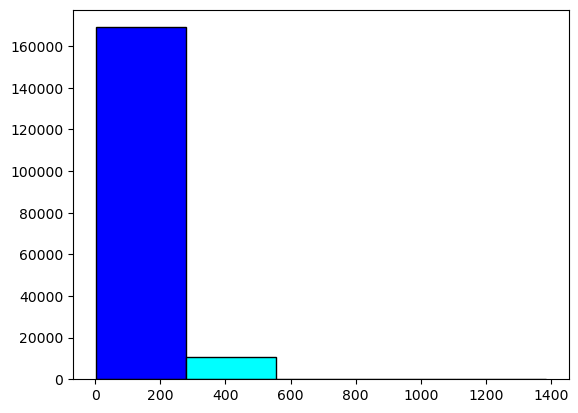

In [54]:
# Crear el histograma
n, bins, patches = plt.hist(char_lens, bins=5, edgecolor='black')

# Colores para cada barra
colors = ['blue', 'cyan', 'green', 'purple', 'orange']

# Asignar un color a cada barra
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# Mostrar el gráfico
plt.show()

In [55]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [58]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'